<a href="https://colab.research.google.com/github/parkminjin99/18_AI_project/blob/main/18_AI_Project_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요한 라이브러리 설치

In [ ]:
!pip install pefile
!pip install numpy
!pip install sklearn
!pip install lightgbm
!pip install tqdm
!pip install pandas
!pip install graphviz
!pip install overload
!pip install lief

### 구글 드라이브 연동 및 데이터 다운로드

In [54]:
from google.colab import drive 
drive_path = '/content/gdrive/'
drive.mount(drive_path)

import sys
sys.path.append(drive_path + "My Drive")

Mounted at /content/gdrive/


In [ ]:
!unzip /content/drive/My\ Drive/데이터.zip

### 사용할 헤더

In [41]:
## Tutorial
import os
import glob
import json
import pprint

import numpy as np

from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE

## PE-Miner
# import  peminer
import pickle
import seaborn as sns
from overload import overload

## Ember
# import  ember
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

%matplotlib inline

### 파일 읽기

In [42]:
def read_label_csv(path):
    label_table = dict()
    with open(path, "r", encoding = "cp949") as f: #csv파일을 읽는다
        for line in f.readlines()[1:]:
            fname, label = line.strip().split(",")
            label_table[fname] = int(label)
    return label_table

def read_json(path):
    with open(path, "r") as f:  #json파일을 읽는다 
        return json.load(f)

In [43]:
learn_label_table = read_label_csv("학습데이터_정답.csv")
verify_label_table = read_label_csv("검증데이터_정답.csv")

###특징 벡터 생성 예시

*   PEMINER 정보는 모두 수치형 데이터이므로 특별히 가공을 하지 않고 사용 가능
*   EMBER, PESTUDIO 정보는 가공해서 사용해야 할 특징들이 있음 (e.g. imports, exports 등의 문자열 정보를 가지는 데이터)
*   수치형 데이터가 아닌 데이터(범주형 데이터)를 어떻게 가공할 지가 관건 >> 인코딩 (e.g. 원핫인코딩, 레이블인코딩 등)


In [44]:
ember_path = "EMBER/학습데이터/000c4ae5e00a1d4de991a9decf9ecbac59ed5582f5972f05b48bc1a1fe57338a.json"
peminer_path = "PEMINER/학습데이터/000c4ae5e00a1d4de991a9decf9ecbac59ed5582f5972f05b48bc1a1fe57338a.json"
pestudio_path = "PESTUDIO/학습데이터/bda2ab110f80f6fa79b3d650b6ae4565d8e840d7ba5b69e38c2874f63cc423a8.json"

ember_result = read_json(ember_path)
peminer_result = read_json(peminer_path)
pestudio_result = read_json(pestudio_path)

In [ ]:
pprint.pprint(ember_result)

In [ ]:
pprint.pprint(peminer_result)

In [ ]:
pprint.pprint(pestudio_result,depth = 2)

> #### PE-Miner



In [45]:
class PeminerParser:
    def __init__(self, path):
        self.report = read_json(path)
        self.vector = []
    
    def process_report(self):
        '''
            전체 데이터 사용        
        '''
        self.vector = [value for _, value in sorted(self.report.items(), key=lambda x: x[0])]
        return self.vector



> #### Ember



In [46]:
class EmberParser:
    '''
        예제에서 사용하지 않은 특징도 사용하여 벡터화 할 것을 권장
    '''
    def __init__(self, path):
        self.report = read_json(path)
        self.vector = []
    
    def get_histogram_info(self):
        histogram = np.array(self.report["histogram"])
        total = histogram.sum()
        vector = histogram / total
        return vector.tolist()
    
    def get_string_info(self):
        strings = self.report["strings"]

        hist_divisor = float(strings['printables']) if strings['printables'] > 0 else 1.0
        vector = [
            strings['numstrings'], 
            strings['avlength'], 
            strings['printables'],
            strings['entropy'], 
            strings['paths'], 
            strings['urls'],
            strings['registry'], 
            strings['MZ']
        ]
        vector += (np.asarray(strings['printabledist']) / hist_divisor).tolist()
        return vector
    
    def get_general_file_info(self):
        general = self.report["general"]
        vector = [
            general['size'], general['vsize'], general['has_debug'], general['exports'], general['imports'],
            general['has_relocations'], general['has_resources'], general['has_signature'], general['has_tls'],
            general['symbols']
        ]
        return vector

    def process_report(self):
        vector = []
        vector += self.get_general_file_info()
        vector += self.get_histogram_info()
        vector += self.get_string_info()
        '''
            특징 추가
        '''
        return vector



> #### PEstudio



In [47]:
class PestudioParser:
    '''
        사용할 특징을 선택하여 벡터화 할 것을 권장
    '''
    
    def __init__(self, path):
        self.report = read_json(path)
        self.vector = []
    
    def process_report(self):
        pass

### 학습데이터 구성


> #### PE-Miner

In [48]:
import os
import queue

peminer_data = []

def get_subdir(path):
    global peminer_data
    try:  # 검색이 허가되지 않은 디렉토리 접근에 관한 예외처리
        dirfiles = os.listdir(path)  # path에 해당하는 디렉토리 dirfiles에 추가
    except PermissionError:
        return []

    subdir_list = []
    for each in dirfiles:
        if each.endswith(".json"):  # .txt로 끝나는 파일은 따로 all_txt리스트에 저장
            peminer_data.append(path + each)
        full_name = path + each  # path와 each(디렉토리)
        if os.path.isdir(full_name):
            subdir_list.append(full_name + "/")
    return subdir_list


dir_queue = queue.Queue()
# /Library/ 아래의 모든 하위 디렉토리 찾기
dir_queue.put("PEMINER/학습데이터/")  # 검색하고자 하는 디렉토리를 줄 앞에 세움

while not dir_queue.empty():  # 큐가 비어있는 상태인지 확인
    dir_name = dir_queue.get()  # 큐에서 빼낸 dir_name
    subdir_names = get_subdir(dir_name)  # dir_name의 하위 디렉토리를 subdir_names에 저장
    for each in subdir_names:  # subdir_names리스트에 있는 디렉토리들을 다시 큐에 넣음
        dir_queue.put(each)

for dir in peminer_data:
    print(dir)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
PEMINER/학습데이터/55479fc0d44eb0aed7cb62e3ac8edbabc2ade73d074eb99be26be1f04f6bfa8f.json
PEMINER/학습데이터/265b16f778fe87a569a1e739e50cc16133d484850e080e335d66f1ac1a9f4fc4.json
PEMINER/학습데이터/24995ead490a412a3e0b5300ce0b69dd1d832a781de1f394cf6421f91847a81b.json
PEMINER/학습데이터/23f32c136e981c16332fdf7083d303dd2d7ca96d2d5b13c8e43a6fed5646f6a7.json
PEMINER/학습데이터/6cf4ab191db0708a72668c3c01090877abcaa3fb117714d29dd6a97e18570c4e.json
PEMINER/학습데이터/89a7353372cae24d08a8cb4b4680fb2e4816179c6e901092b69c25d6532f9906.json
PEMINER/학습데이터/256e181d8cb9716e52cff9902fde9eee4507566d0c70de6d8c64f8073c756a82.json
PEMINER/학습데이터/c82a4b509808c9f0558bffe35b11291dba51f7d22d6c13f11745d62f53b4077c.json
PEMINER/학습데이터/3c76b33c4ba6db6631850190986feacbb1cf084ae19425cf618d01ddcaf66d18.json
PEMINER/학습데이터/dcfe947b7463c7b513524147bb7e1d6c33c8a03a12746865421c22f86f648432.json
PEMINER/학습데이터/2dab274241a082f72784a57ad02013132fee352f2b3e407d50f6d25aeeb5e416.json
PEMINER/학습데이터/3d702178abad6b56043600d5fe

> #### Ember

In [ ]:
import os
import queue

ember_data = []

def get_subdir(path):
    global ember_data
    try:  # 검색이 허가되지 않은 디렉토리 접근에 관한 예외처리
        dirfiles = os.listdir(path)  # path에 해당하는 디렉토리 dirfiles에 추가
    except PermissionError:
        return []

    subdir_list = []
    for each in dirfiles:
        if each.endswith(".json"):  # .txt로 끝나는 파일은 따로 all_txt리스트에 저장
            ember_data.append(path + each)
        full_name = path + each  # path와 each(디렉토리)
        if os.path.isdir(full_name):
            subdir_list.append(full_name + "/")
    return subdir_list


dir_queue = queue.Queue()
# /Library/ 아래의 모든 하위 디렉토리 찾기
dir_queue.put("EMBER/학습데이터/")  # 검색하고자 하는 디렉토리를 줄 앞에 세움

while not dir_queue.empty():  # 큐가 비어있는 상태인지 확인
    dir_name = dir_queue.get()  # 큐에서 빼낸 dir_name
    subdir_names = get_subdir(dir_name)  # dir_name의 하위 디렉토리를 subdir_names에 저장
    for each in subdir_names:  # subdir_names리스트에 있는 디렉토리들을 다시 큐에 넣음
        dir_queue.put(each)

for dir in ember_data:
    print(dir)

> #### PE-Miner + Ember

In [ ]:
# 데이터의 특징 벡터 모음(2차원 리스트) : X
# 데이터의 레이블 모음(1차원 리스트) : y
X, y = [], []

for path in peminer_data:
  feature_vector = []
  temp, fdata, fname = path.strip().split("/")
  fname = fname.replace(".json","")
  label = learn_label_table[fname]
  for data in ["PEMINER", "EMBER"]:
        path = f"{data}/{fdata}/{fname}.json"
        if data == "PEMINER":
            feature_vector += PeminerParser(path).process_report()
        else:
            feature_vector += EmberParser(path).process_report()
  X.append(feature_vector)
  y.append(label)

for path in ember_data:
  feature_vector = []
  temp, fdata, fname = path.strip().split("/")
  fname = fname.replace(".json","")
  label = learn_label_table[fname]
  for data in ["PEMINER", "EMBER"]:
        path = f"{data}/{fdata}/{fname}.json"
        if data == "PEMINER":
            feature_vector += PeminerParser(path).process_report()
        else:
            feature_vector += EmberParser(path).process_report()
  X.append(feature_vector)
  y.append(label)

np.asarray(X).shape, np.asarray(y).shape

((40000, 558), (40000,))

In [ ]:
X, y = [], []
for fname_ in ["학습데이터/000c4ae5e00a1d4de991a9decf9ecbac59ed5582f5972f05b48bc1a1fe57338a", "학습데이터/00ed7bc707559e6e63818b2bba0ac6b338ba17d95aea6f0838cbdc40cb9acd94"]:
    feature_vector = []
    fdata, fname = fname_.strip().split("/")
    label = learn_label_table[fname]
    for data in ["PEMINER", "EMBER"]:
        path = f"{data}/{fname_}.json"
        if data == "PEMINER":
            feature_vector += PeminerParser(path).process_report()
        else:
            feature_vector += EmberParser(path).process_report()
    X.append(feature_vector)
    y.append(label)

np.asarray(X).shape, np.asarray(y).shape

((2, 558), (2,))

### 검증데이터 구성

> #### PE-Miner

In [ ]:
import os
import queue

peminer_veri_data = []

def get_subdir(path):
    global peminer_veri_data
    try:  # 검색이 허가되지 않은 디렉토리 접근에 관한 예외처리
        dirfiles = os.listdir(path)  # path에 해당하는 디렉토리 dirfiles에 추가
    except PermissionError:
        return []

    subdir_list = []
    for each in dirfiles:
        if each.endswith(".json"):  # .txt로 끝나는 파일은 따로 all_txt리스트에 저장
            peminer_veri_data.append(path + each)
        full_name = path + each  # path와 each(디렉토리)
        if os.path.isdir(full_name):
            subdir_list.append(full_name + "/")
    return subdir_list


dir_queue = queue.Queue()
# /Library/ 아래의 모든 하위 디렉토리 찾기
dir_queue.put("PEMINER/검증데이터/")  # 검색하고자 하는 디렉토리를 줄 앞에 세움

while not dir_queue.empty():  # 큐가 비어있는 상태인지 확인
    dir_name = dir_queue.get()  # 큐에서 빼낸 dir_name
    subdir_names = get_subdir(dir_name)  # dir_name의 하위 디렉토리를 subdir_names에 저장
    for each in subdir_names:  # subdir_names리스트에 있는 디렉토리들을 다시 큐에 넣음
        dir_queue.put(each)

for dir in peminer_veri_data:
    print(dir)

> #### Ember

In [ ]:
import os
import queue

ember_veri_data = []

def get_subdir(path):
    global ember_veri_data
    try:  # 검색이 허가되지 않은 디렉토리 접근에 관한 예외처리
        dirfiles = os.listdir(path)  # path에 해당하는 디렉토리 dirfiles에 추가
    except PermissionError:
        return []

    subdir_list = []
    for each in dirfiles:
        if each.endswith(".json"):  # .txt로 끝나는 파일은 따로 all_txt리스트에 저장
            ember_veri_data.append(path + each)
        full_name = path + each  # path와 each(디렉토리)
        if os.path.isdir(full_name):
            subdir_list.append(full_name + "/")
    return subdir_list


dir_queue = queue.Queue()
# /Library/ 아래의 모든 하위 디렉토리 찾기
dir_queue.put("EMBER/검증데이터/")  # 검색하고자 하는 디렉토리를 줄 앞에 세움

while not dir_queue.empty():  # 큐가 비어있는 상태인지 확인
    dir_name = dir_queue.get()  # 큐에서 빼낸 dir_name
    subdir_names = get_subdir(dir_name)  # dir_name의 하위 디렉토리를 subdir_names에 저장
    for each in subdir_names:  # subdir_names리스트에 있는 디렉토리들을 다시 큐에 넣음
        dir_queue.put(each)

for dir in ember_veri_data:
    print(dir)

> #### PE-Miner + Ember

In [ ]:
# 데이터의 특징 벡터 모음(2차원 리스트) : X
# 데이터의 레이블 모음(1차원 리스트) : y
A, b = [], []

for path in peminer_veri_data:
  feature_vector = []
  temp, fdata, fname = path.strip().split("/")
  fname = fname.replace(".json","")
  label = verify_label_table[fname]
  for data in ["PEMINER", "EMBER"]:
        path = f"{data}/{fdata}/{fname}.json"
        if data == "PEMINER":
            feature_vector += PeminerParser(path).process_report()
        else:
            feature_vector += EmberParser(path).process_report()
  A.append(feature_vector)
  b.append(label)

for path in ember_veri_data:
  feature_vector = []
  temp, fdata, fname = path.strip().split("/")
  fname = fname.replace(".json","")
  label = verify_label_table[fname]
  for data in ["PEMINER", "EMBER"]:
        path = f"{data}/{fdata}/{fname}.json"
        if data == "PEMINER":
            feature_vector += PeminerParser(path).process_report()
        else:
            feature_vector += EmberParser(path).process_report()
  A.append(feature_vector)
  b.append(label)

np.asarray(A).shape, np.asarray(b).shape

((20000, 558), (20000,))

### 학습 및 검증

In [49]:
SEED = 41

def load_model(**kwargs):
    if kwargs["model"] == "rf":
        return RandomForestClassifier(random_state=kwargs["random_state"], n_jobs=4)
    elif kwargs["model"] == "dt": # decision tree
        return DecisionTreeClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lgb":
        return LGBMClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "svm":
        return SVC(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lr":
        return LogisticRegression(random_state=kwargs["random_state"], n_jobs=-1)
    elif kwargs["model"] == "knn":
        return KNeighborsClassifier(n_jobs=-1)
    elif kwargs["model"] == "adaboost":
        return AdaBoostClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "mlp":
        return MLPClassifier(random_state=kwargs["random_state"])
    else:
        print("Unsupported Algorithm")
        return None

def train(X_train, y_train, model):
    '''
        머신러닝 모델을 선택하여 학습을 진행하는 함수
	
        :param X_train: 학습할 2차원 리스트 특징벡터
        :param y_train: 학습할 1차원 리스트 레이블 벡터
        :param model: 문자열, 선택할 머신러닝 알고리즘
        :return: 학습된 머신러닝 모델 객체
    '''
    clf = load_model(model=model, random_state=SEED)
    clf.fit(X_train, y_train)
    return clf

def evaluate(X_test, y_test, model):
    '''
        학습된 머신러닝 모델로 검증 데이터를 검증하는 함수
	
        :param X_test: 검증할 2차원 리스트 특징 벡터
        :param y_test: 검증할 1차원 리스트 레이블 벡터
        :param model: 학습된 머신러닝 모델 객체
    '''
    predict = model.predict(X_test)
    print("정확도", model.score(X_test, y_test))


In [ ]:
# 학습
models = []
for model in ["rf", "lgb"]:
    clf = train(X, y, model)
    models.append(clf)

# 검증
# 실제 검증 시에는 제공한 검증데이터를 검증에 사용해야 함
for model in models:
    evaluate(A, b, model)

정확도 0.7424
정확도 0.27


### 앙상블 예제

In [ ]:
def ensemble_result(X, y, models):
    '''
        학습된 모델들의 결과를 앙상블하는 함수
	
        :param X: 검증할 2차원 리스트 특징 벡터
        :param y: 검증할 1차원 리스트 레이블 벡터
        :param models: 1개 이상의 학습된 머신러닝 모델 객체를 가지는 1차원 리스트
    '''
    
    # Soft Voting
    # https://devkor.tistory.com/entry/Soft-Voting-%EA%B3%BC-Hard-Voting
    predicts = []
    for i in range(len(X)):
        probs = []
        for model in models:
            prob = model.predict_proba(X)[i][1]
            probs.append(prob)
        predict = 1 if np.mean(probs) >= 0.5 else 0
        predicts.append(predict)
        
    print("정확도", accuracy_score(y, predicts))

In [ ]:
ensemble_result(A, b, models)

KeyboardInterrupt: ignored

### 특징 선택 예제 (RFE 알고리즘 사용)

In [ ]:
def select_feature(X, y, model):
    '''
        주어진 특징 벡터에서 특정 알고리즘 기반 특징 선택
        
        본 예제에서는 RFE 알고리즘 사용
        https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE.fit_transform
        
        :param X: 검증할 2차원 리스트 특징 벡터
        :param y: 검증할 1차원 리스트 레이블 벡터
        :param model: 문자열, 특징 선택에 사용할 머신러닝 알고리즘
    '''
    
    model = load_model(model=model, random_state=SEED)
    rfe = RFE(estimator=model)
    return rfe.fit_transform(X, y)

selected_X = select_feature(X, y, "rf")
new_model = train(selected_X, y, "rf")

### 피처 추출

> #### PE-Miner로

In [50]:
# PEMINER 에서 사용한 특징의 이름
peminer_header = ['ADVAP132.DLL', 'AWFAXP32.DLL', 'AWFXAB32.DLL', 'AWPWD32.DLL', 'AWRESX32.DLL', 'AWUTIL32.DLL', 'BHNETB.DLL', 'BHSUPP.DLL', 'CCAPI.DLL', 'CCEI.DLL', 'CCPSH.DLL', 'CCTN20.DLL', 'CMC.DLL', 'COMCTL32.DLL', 'COMDLG32.DLL', 'CRTDLL.DLL', 'DCIMAN.DLL', 'DCIMAN32.DLL', 'DSKMAINT.DLL', 'FileHeader.Characteristics', 'FileHeader.Machine', 'FileHeader.NumberOfSections', 'FileHeader.NumberOfSymbols', 'FileHeader.PointerToSymbolTable', 'FileHeader.SizeOfOptionalHeader', 'FileHeader.TimeDateStamp', 'GDI32.DLL', 'GROUP.DLL', 'HYPERTERM.DLL', 'KERNL32.DLL', 'LZ32.DLL', 'MAPI.DLL', 'MAPI32.DLL', 'MFC30.DLL', 'MPR.DLL', 'MSFS32.DLL', 'MSNDUI.DLL', 'MSNET32.DLL', 'MSPST32.DLL', 'MSSHRUI.DLL', 'MSVIEWUT.DLL', 'NAL.DLL', 'NDIS30.DLL', 'NETAPI.DLL', 'NETAPI32.DLL', 'NETBIOS.DLL', 'NETDI.DLL', 'NETSETUP.DLL', 'NWAB32.DLL', 'NWNET32.DLL', 'NWNP32.DLL', 'OLEDLG.DLL', 'OptionalHeader.AddressOfEntryPoint', 'OptionalHeader.BaseOfCode', 'OptionalHeader.BaseOfData', 'OptionalHeader.CheckSum', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BASERELOC.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BASERELOC.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BOUND_IMPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_BOUND_IMPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_COM_DESCRIPTOR.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_COM_DESCRIPTOR.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DEBUG.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DEBUG.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DELAY_IMPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_DELAY_IMPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXCEPTION.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXCEPTION.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_EXPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_GLOBALPTR.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_GLOBALPTR.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IAT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IAT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IMPORT.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_IMPORT.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_LOAD_CONFIG.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_LOAD_CONFIG.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESERVED.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESERVED.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESOURCE.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_RESOURCE.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_SECURITY.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_SECURITY.VirtualAddress', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_TLS.Size', 'OptionalHeader.DataDirectory.IMAGE_DIRECTORY_ENTRY_TLS.VirtualAddress', 'OptionalHeader.DllCharacteristics', 'OptionalHeader.FileAlignment', 'OptionalHeader.ImageBase', 'OptionalHeader.LoaderFlags', 'OptionalHeader.Magic', 'OptionalHeader.MajorImageVersion', 'OptionalHeader.MajorLinkerVersion', 'OptionalHeader.MajorOperatingSystemVersion', 'OptionalHeader.MajorSubsystemVersion', 'OptionalHeader.MinorImageVersion', 'OptionalHeader.MinorLinkerVersion', 'OptionalHeader.MinorOperatingSystemVersion', 'OptionalHeader.MinorSubsystemVersion', 'OptionalHeader.NumberOfRvaAndSizes', 'OptionalHeader.Reserved1', 'OptionalHeader.SectionAlignment', 'OptionalHeader.SizeOfCode', 'OptionalHeader.SizeOfHeaders', 'OptionalHeader.SizeOfHeapCommit', 'OptionalHeader.SizeOfHeapReserve', 'OptionalHeader.SizeOfImage', 'OptionalHeader.SizeOfInitializedData', 'OptionalHeader.SizeOfStackCommit', 'OptionalHeader.SizeOfStackReserve', 'OptionalHeader.SizeOfUninitializedData', 'OptionalHeader.Subsystem', 'POWERCFG.DLL', 'RASAPI16.DLL', 'RASAPI32.DLL', 'RASPI.DLL', 'RPCLTC1.DLL', 'RPCNS4.DLL', 'RPCRT4.DLL', 'RPCTLC3.DLL', 'RPCTLC5.DLL', 'RPCTLC6.DLL', 'RPCTLS3.DLL', 'RPCTLS5.DLL', 'RPCTLS6.DLL', 'RSRC32.DLL', 'Resource.Characteristics', 'Resource.MajorVersion', 'Resource.MinorVersion', 'Resource.NumberOfIdEntries', 'Resource.NumberOfNamedEntries', 'Resource.RT_ACCELERATOR', 'Resource.RT_BITMAP', 'Resource.RT_CURSOR', 'Resource.RT_DIALOG', 'Resource.RT_DLGINCLUDE', 'Resource.RT_FONT', 'Resource.RT_FONTDIR', 'Resource.RT_GROUP_CURSOR', 'Resource.RT_GROUP_ICON', 'Resource.RT_ICON', 'Resource.RT_MENU', 'Resource.RT_MESSAGETABLE', 'Resource.RT_RCDATA', 'Resource.RT_STRING', 'Resource.RT_VERSION', 'Resource.TimeDateStamp', 'SAPNSP.DLL', 'SECUR32.DLL', 'SHELL32.DLL', 'SHLWAPI.DLL', 'SLENH.DLL', 'Section.data.Characteristics', 'Section.data.NumberOfLinenumbers', 'Section.data.NumberOfRelocations', 'Section.data.PointerToLinenumbers', 'Section.data.PointerToRawData', 'Section.data.PointerToRelocations', 'Section.data.SizeOfRawData', 'Section.data.VirtualAddress', 'Section.data.VirtualSize', 'Section.rsrc.Characteristics', 'Section.rsrc.NumberOfLinenumbers', 'Section.rsrc.NumberOfRelocations', 'Section.rsrc.PointerToLinenumbers', 'Section.rsrc.PointerToRawData', 'Section.rsrc.PointerToRelocations', 'Section.rsrc.SizeOfRawData', 'Section.rsrc.VirtualAddress', 'Section.rsrc.VirtualSize', 'Section.text.Characteristics', 'Section.text.NumberOfLinenumbers', 'Section.text.NumberOfRelocations', 'Section.text.PointerToLinenumbers', 'Section.text.PointerToRawData', 'Section.text.PointerToRelocations', 'Section.text.SizeOfRawData', 'Section.text.VirtualAddress', 'Section.text.VirtualSize', 'UMDM32.DLL', 'USER32.DLL', 'VERSION.DLL', 'WININET.DLL', 'WINMM.DLL', 'WINREG.DLL', 'WINSOCK.DLL', 'WS2.DLL', 'WSOCK32.DLL']

In [51]:
# 피클 파일 로드
def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

# 피클 파일 저장
def save_pickle(path, data):
    with open(path, "wb") as f:
        pickle.dump(data, f)

> #### Ember로

In [52]:
def read_bytes(path):
    with open(path, "rb") as f:
        return f.read()

In [58]:
drive_path = '/content/drive/'
example_path = os.path.join(drive_path, "My Drive", "sample.exe")

raw = read_bytes(example_path)
generator = ember.PEFeatureExtractor()

generator.raw_features(raw)

FileNotFoundError: ignored

In [ ]:
generator.feature_vector(raw)

In [ ]:
def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

### 데이터 로드

> #### PE-Miner

전체 데이터 특징 추출 및 저장 예제 코드

In [59]:
data = []
for path in paths:
    # 각 파일의 피처 추출 후 피처 벡터 생성
    vector = np.array([ value for _, value in sorted(peminer.extract_feature(path).items(), key=lambda x : x[0])])
    data.append(vector)
save_pickle("data_path.pkl", data)

NameError: ignored

In [68]:
fname_train = np.load(os.path.join(drive_path, "My Drive", "new_peminer_train_fnames.npy"))
X_train = pd.DataFrame(np.load(os.path.join(drive_path, "My Drive", "new_peminer_train_features.npy")), columns=peminer_header)
y_train = np.load(os.path.join(drive_path, "My Drive", "new_peminer_train_labels.npy"))

fname_test = np.load(os.path.join(drive_path, "My Drive", "new_peminer_test_fnames.npy"))
X_test = pd.DataFrame(np.load(os.path.join(drive_path, "My Drive", "new_peminer_test_features.npy")), columns=peminer_header)
y_test = np.load(os.path.join(drive_path, "My Drive", "new_peminer_test_labels.npy"))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 188)
(20000,)
(20000, 188)
(20000,)


> #### Ember

In [64]:
X_train = read_pickle(os.path.join(drive_path, "My Drive", "ember_train_features.pkl"))
y_train = read_pickle(os.path.join(drive_path, "My Drive", "ember_train_labels.pkl"))

X_test = read_pickle(os.path.join(drive_path, "My Drive", "ember_test_features.pkl"))
y_test = read_pickle(os.path.join(drive_path, "My Drive", "ember_test_labels.pkl"))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 2381)
(20000,)
(20000, 2381)
(20000,)


### 학습 및 테스트

In [65]:
# 고정 시드값
SEED = 41

# 학습 알고리즘 선택 함수
def load_model(**kwargs):
    if kwargs["model"] == "rf":
        return RandomForestClassifier(random_state=kwargs["random_state"], n_jobs=4)
    elif kwargs["model"] == "dt":
        return DecisionTreeClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lgb":
        return LGBMClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "svm":
        return SVC(random_state=kwargs["random_state"])
    elif kwargs["model"] == "lr":
        return LogisticRegression(random_state=kwargs["random_state"], n_jobs=-1)
    elif kwargs["model"] == "knn":
        return KNeighborsClassifier(n_jobs=-1)
    elif kwargs["model"] == "adaboost":
        return AdaBoostClassifier(random_state=kwargs["random_state"])
    elif kwargs["model"] == "mlp":
        return MLPClassifier(random_state=kwargs["random_state"])
    else:
        print("Unsupported Algorithm")
        return None



> #### PE-Miner


In [69]:
import hashlib
import pprint

def train(X_train, y_train, model="rf"):
    print(X_train.shape)

    # 학습 알고리즘 불러오기
    # 랜덤 포레스트 : rf
    # 의사결정 트리 : dt
    # lightgbm : lgb
    # svm : svm
    # logistic regression : lr
    # knn : knn
    # adaboost : adaboost
    # mlp : mlp
    clf = load_model(model=model, random_state=SEED)
    # 학습
    clf.fit(X_train, y_train)
    return clf


def evaluate(clf, X_test, y_test):
    # 예측
    predict = clf.predict(X_test)

    # 성능 확인
    print("accuracy", clf.score(X_test, y_test))
    print("precision", precision_score(y_test, predict))
    print("recall", recall_score(y_test, predict))
    print("f1-score", f1_score(y_test, predict))
    
    # 틀린파일
    wrongs = list(zip(X_test[y_test != predict], y_test[y_test != predict]))
    return wrongs


clf = train(X_train, y_train, model="rf")
_ = evaluate(clf, X_test, y_test)

(20000, 188)
accuracy 0.9542
precision 0.9713419674841555
recall 0.9657534246575342
f1-score 0.9685396345651877




> #### Ember



In [67]:
clf = load_model(model="lgb", random_state=SEED)
clf.fit(X_train, y_train)

predict = clf.predict(X_test)

print("accuracy", clf.score(X_test, y_test))
print("precision", precision_score(y_test, predict))
print("recall", recall_score(y_test, predict))
print("f1-score", f1_score(y_test, predict))

accuracy 0.95505
precision 0.9739190591490834
recall 0.9642465753424657
f1-score 0.9690586818103596


### 판별 분기

In [70]:
from sklearn import tree

for dtree in clf.estimators_[:1]:
    tree.export_graphviz(dtree
                            , max_depth=2
                            , out_file='tree.dot'
                            , feature_names=peminer_header
                            , class_names=['benign', 'mal']
                            , filled=True
                            , rounded=True
                            , special_characters=True)

    # Convert to png using system command (requires Graphviz)
    os.system('dot ' + '-Tpng ' + 'tree.dot ' + '-o ' + 'tree.png ')

### 특징 중요도 그래프

> #### PE-Miner

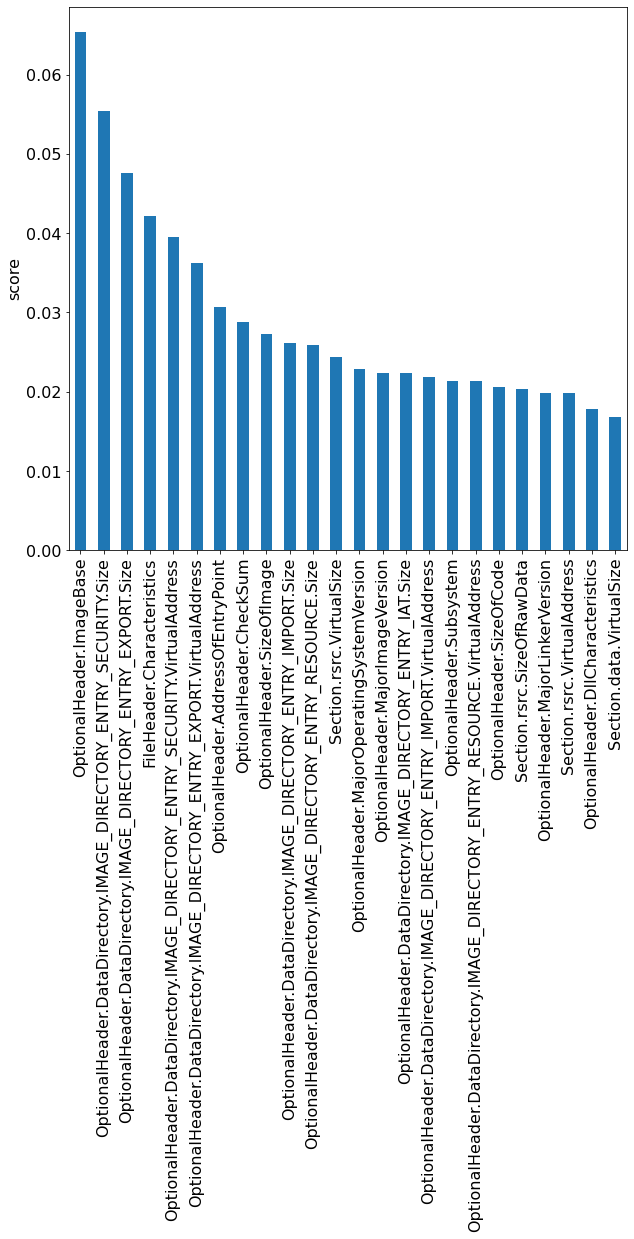

In [71]:
def draw_feature_importance_plot():
    plt.figure(figsize=(10, 10))
    feat_importances = pd.Series(clf.feature_importances_, index=peminer_header)
    feat_importances.nlargest(24).plot(kind='bar')
    plt.ylabel("score", fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    plt.savefig("peminer importance")

draw_feature_importance_plot()

> #### Ember

In [ ]:
section, dll, function, eat = 50, 256, 1024, 128    

header = [f"Byte Histogram {i}" for i in range(256)] +\
[f"Byte Entropy Histogram {i}" for i in range(256)] +\
[f"String Info {i}" for i in range(104)]+\
[f"General File Info {i}" for i in range(10)]+\
[f"Header Info {i}" for i in range(62)]+\
[f"Section(General) {i}" for i in range(5)]+\
[f"Section(Size) {i}" for i in range(section)]+\
[f"Section(Entropy) {i}" for i in range(section)]+\
[f"Section(Virtual Size) {i}" for i in range(section)]+\
[f"Section(Entry) {i}" for i in range(section)]+\
[f"Section(Characteristic) {i}" for i in range(section)]+\
[f"Imports(DLL) {i}" for i in range(dll)]+\
[f"Imports(Function) {i}" for i in range(function)]+\
[f"Exports(Function) {i}" for i in range(eat)]+\
[f"Data Directory {i}" for i in range(30)]


plt.figure(figsize=(10, 10))
feat_importances = pd.Series(clf.feature_importances_, index=header)
feat_importances.nlargest(24).plot(kind='bar')
plt.ylabel("score", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

### 혼동 행렬



> #### PE-Miner



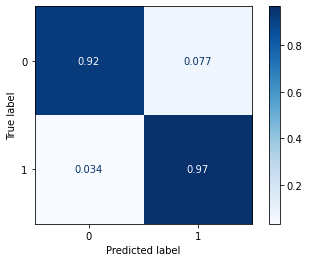

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test, y_test, normalize="true", cmap=plt.cm.Blues)
disp.figure_.savefig("실험3 PEminer") 



> #### Ember



In [ ]:
disp = plot_confusion_matrix(clf, X_test, y_test, normalize="true", cmap=plt.cm.Blues)
disp.figure_.savefig("실험3 Ember")

### 최적 파라미터 탐색 (Grid Search)
- 학습 전, 모델의 최적 파라미터를 찾아 학습하고 싶을 때 사용
- 기본(default) 파라미터 결과와 비교 필수



> #### PE-Miner



피처 차원 줄이기(Feature Selection) : PE-Miner만 하는 과정

In [ ]:
rfe = RFE(estimator=clf)
rfe.fit(X_train, y_train)

pipeline = Pipeline(steps=[("rfe", rfe), ("clf", clf)])

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

In [ ]:
print("현재 랜덤포레스트 파라미터")
pprint(clf.get_params())

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 128, 256, 1024]
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)



> #### Ember



In [ ]:
print("현재 랜덤포레스트 파라미터")
pprint(clf.get_params())

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110, None],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 128, 256, 1024]
}
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
pprint(grid_search.best_params_)

best_grid = grid_search.best_estimator_

In [ ]:
clf.set_params(**grid_search.best_params_)

In [ ]:
best_grid.score(X_test, y_test)

### 참고자료

#### [PE-Miner]

- #### 피처 추출 코드 : https://bit.ly/3amOhp2

- #### 샘플 : https://bit.ly/31P7Z98

- #### 학습 데이터 이름 : http://tiny.cc/9cdzsz

- #### 학습 데이터 : http://tiny.cc/1cdzsz

- #### 학습 라벨 : http://tiny.cc/gcdzsz

- #### 검증 데이터 이름 : http://tiny.cc/2edzsz

- #### 검증 데이터 : http://tiny.cc/zddzsz

- #### 검증 라벨 : http://tiny.cc/4edzsz


#### [Ember]
- #### 피처 추출 코드 : https://bit.ly/3gWqxuj

- #### 학습 데이터 : https://bit.ly/2FkqtXn

- #### 학습 라벨 : https://bit.ly/3amlIYV

- #### 검증 데이터 : https://bit.ly/2PMXPQO

- #### 검증 라벨 : https://bit.ly/2XYGbOe